### Import main libraries

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

### Define image properties

In [2]:
img_width = 128
img_height = 128
img_size = (img_width, img_height)
img_channels = 3

In [3]:
img_names = os.listdir('train')
categories = []
for name in img_names:
    # cat or dog (cat.50, dog.123)
    cate = name.split('.')[0].lower()
    # if cate == 'cat':
    #     categories.append(0)
    # else: 
    #     categories.append(1)
    categories.append(cate)
df = pd.DataFrame({
    'img_name' : img_names,
    'category' : categories
})
df.head()

,img_name,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


,img_name,category
count,25000,25000
unique,25000,2
top,cat.0.jpg,cat
freq,1,12500


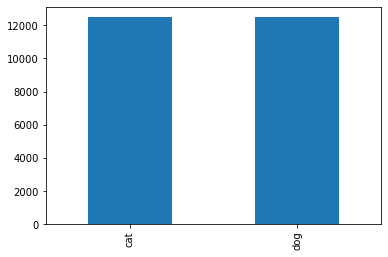

In [4]:
df['category'].value_counts().plot.bar()
df.describe(include='all')

In [5]:
train, valid = train_test_split(df, test_size=0.2, random_state=42)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train['category'].value_counts()

dog    10015
cat     9985
Name: category, dtype: int64

In [6]:
valid['category'].value_counts()

cat    2515
dog    2485
Name: category, dtype: int64

## Create the CNN model

### Importing:-

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

### Model creation:-

In [8]:
model = Sequential()
# Input shape and 1st hidden layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, img_channels)))
# BatchNormalization Layer normalizes its inputs
model.add(BatchNormalization())
# The pooling window reduce the spatial volume of input image after convolution(moves for each pooling step(pool_size here because strides is none))
model.add(MaxPooling2D(pool_size=(2, 2)))
# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
# p is the probability of the activations to the shut off.
# if p is too small (p = 0.01) --> overfitting  , too larg (p = 0.9) --> underfitting
# It'll be turned off for the evaluation
model.add(Dropout(0.25))

# 2nd hidden layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd hidden layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Final hidden layer and output layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax is better at o/p than most activations. o/p is 2 (dog or cat)
model.add(Dense(2, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## 

## Callbacks & learning rate:-

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

## Generators:-

In [12]:
batch_size = 15

### 1-Train

In [13]:
# Generate batches of tensor image data with real-time data augmentation
# The model will give better results when you train it with data having problems like real world
# Also good to avoid overfitting
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255, shear_range=0.1,
                                  zoom_range=0.2, horizontal_flip=True,
                                  width_shift_range=0.1, height_shift_range=0.1)

# Takes the dataframe and the path to a directory + generates batches.
# The generated batches contain augmented/normalized data.
train_generator = train_datagen.flow_from_dataframe(train, "train/", 
    x_col='img_name', y_col='category', target_size=img_size, 
    class_mode='categorical', batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


### 2-Validation

In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(valid, "train/", 
    x_col='img_name', y_col='category', target_size=img_size,
    class_mode='categorical', batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


### Test the generator

In [15]:
temp_df = train.sample(n=1).reset_index(drop=True)
temp_generator = train_datagen.flow_from_dataframe(temp_df, 'train/', 
                                                   x_col='img_name', y_col='category', 
                                                   traget_size=img_size, 
                                                   class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


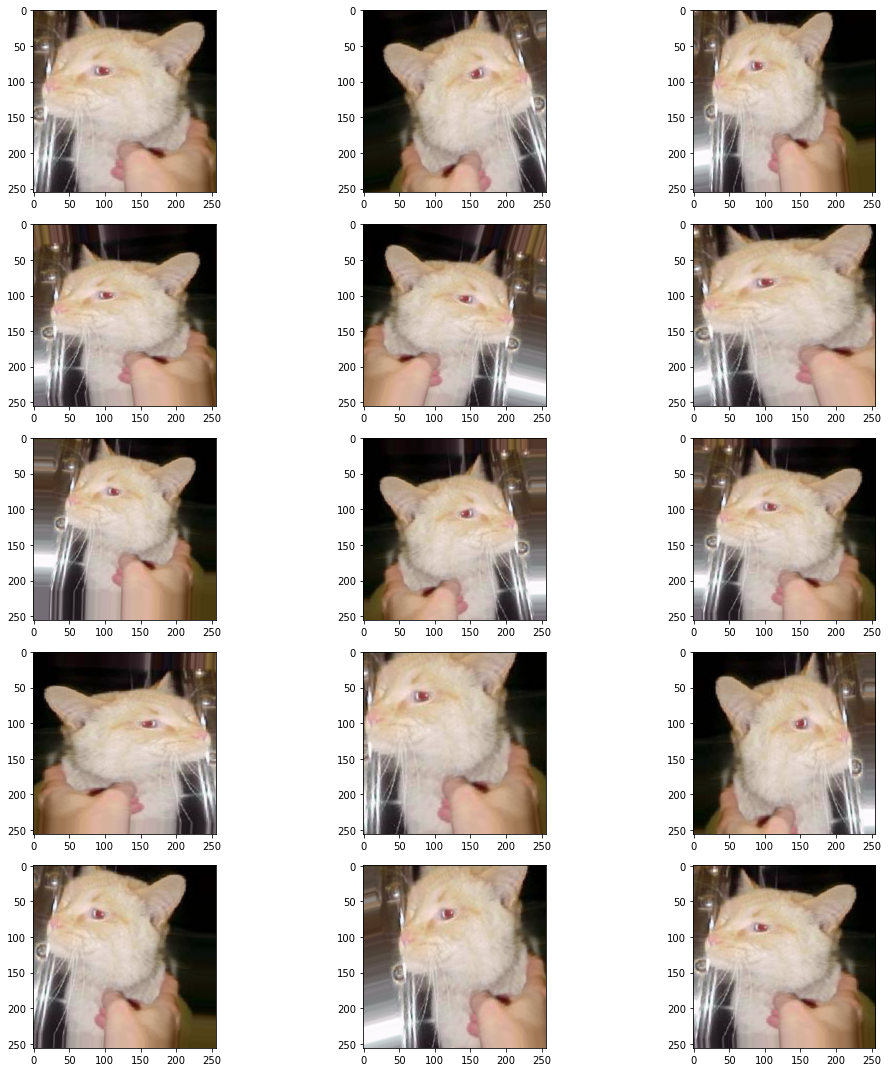

In [16]:
plt.figure(figsize=(15, 15))
for i in range(0, 15):
    # 5 rows, 3 columns index start from 1 to 15(i+1)
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in temp_generator:
        im = X_batch[0]
        plt.imshow(im)
        break
plt.tight_layout()
plt.show()

## Train the model

In [ ]:
epochs = 3
# Total train and valid
train_shape = train.shape[0]
valid_shape = valid.shape[0]
history = model.fit(train_generator, epochs=epochs, 
                              validation_data=validation_generator,
                              validation_steps=valid_shape//batch_size,
                              steps_per_epoch=train_shape//batch_size,
                              callbacks=callbacks)
model.save("model_name.h5")
model = tf.keras.models.load_model("cats_vs_dogs.h5")



In [ ]:
from tensorflow.keras.models import load_model
model = load_model("dog_or_cat_model")

## Prepare Testing Data

In [ ]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

## Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })